### Description: Bayesian linear regression using conjugate priors
#### Assumptions: scalar input, scalar output, polynomial basis, known error precision


###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

Bayesian linear regression is a probabilistic framework to estimate the parameters of a linear-in-parameter models using Bayesian inference. When using conjugate prior distribution for the model parameters, Bayesian linear regression provides analytical solution to the posterior parameter pdf, model evidence, and posterior predictive distribution. In matrix notation
\begin{align*}
\text{Observations:  } \;\; & Y \in \mathbb{R}^{M \times 1}  = \{y_1,y_2,\ldots,y_{M}\}^T \\
\text{Model input: } \;\; & X \in \mathbb{R}^{d \times 1}  = \{x_1,x_2,\ldots,x_{d}\}^T \\
\text{Model parameter: } \;\; & W \in \mathbb{R}^{N \times 1}  = \{w_0,w_1,\ldots,w_{N-1}\}^T \\
\text{Measurement error: } \;\; & \epsilon \in \mathbb{R}^{M \times 1}  = \{\varepsilon_0,\varepsilon_1,\ldots,\varepsilon_{M}\}^T \\
\text{Design matrix:  } \;\; & \Phi \in \mathbb{R}^{M \times N} = \{\phi_j(X_i); i =1,\ldots,M; j = 0,\ldots,N-1\}
\end{align*}
Assuming conjugate priors, Bayesian inference provides following analytical solution to the inverse problem:
\begin{align*}
\text{Model: } \;\;& Y = \Phi W + \epsilon \\
\text{Measurement noise: }\;\;& p(\epsilon) = \mathcal{N}(0, \Gamma)\\
\text{Prior pdf: }\;\;& p(W) = \mathcal{N}(W|m_0, P_0)\\
\text{Likelihood function: }\;\;& p(Y|W,\rho) = \mathcal{N}(Y|\Phi W, \Gamma) \\
\text{Posterior parameter pdf: }\;\; & p(W|Y,\rho) = \mathcal{N}(W|m,P)\\
& m = \frac{P_0^{-1}}{P^{-1}}m_0 + \frac{\Phi^T \Gamma^{-1}\Phi}{P^{-1}} (\Phi^T\Phi)^{-1}\Phi^T Y \\
& P^{-1} = P_0^{-1} + \Phi^T \Gamma^{-1}\Phi \\
\text{Evidence: }\;\; & p(Y|\rho) = \mathcal{N}(Y|\Phi m_0, \Phi P_0\Phi^T +\Gamma)\\
\text{Predictive distribution: }\;\; & p(Y^*|Y) = \mathcal{N}(Y^*| \Phi^* m, \Phi^* P (\Phi^*)^T + \Gamma)\\
\end{align*}


In [1]:
#!/usr/bin/python
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import math
import sys

Assign polynomial basis (polyPower), hyper-parameters m_0, P_0, and noise precision $\rho$:

In [2]:
polyPower = [0,2] # powers of polynomial basis
M0prior = 1 # virtual sample size for prior assigning
rho = 20 # error precision

In [3]:
N = len(polyPower) # number of coefficients 
m0 = [0]*N # prior mean
P0 = np.identity(N)/(M0prior*rho) # prior covariance matrix

Generate design matrix $\Phi$, and load observations $Y$ and input $X$: 

In [4]:
def PhiMat(X):
    M = len(X)
    Phi = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N):
            Phi[i,j] = X[i]**polyPower[j]
    return Phi
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
Phi = PhiMat(Xobs)
M = len(Yobs)
GamMat = np.identity(M)/rho # noise covriance matrix

Bayesian update using observations to obtain posterior pdf and model evidence:

In [5]:
WwlsPrec = np.matmul(np.matmul(np.transpose(Phi),np.linalg.inv(GamMat)),Phi)
Wwls = np.matmul(np.matmul(np.matmul(np.linalg.inv(WwlsPrec),np.transpose(Phi)),np.linalg.inv(GamMat)),Yobs)
P = np.linalg.inv(np.linalg.inv(P0) + WwlsPrec)
m = np.matmul(P,np.matmul(np.linalg.inv(P0),m0) + np.matmul(WwlsPrec,Wwls))
evid = st.multivariate_normal.pdf(Yobs,np.matmul(Phi,m0),np.matmul(Phi,np.matmul(P0,np.transpose(Phi))) + GamMat)
print('  W(Prior): ',m0,'\n   W (WLS): ',Wwls,'\n   W (MAP): ',m,'\n')
print('Var(Prior): ',np.diag(P0),'\n  Var(WLS): ',np.diag(np.linalg.inv(WwlsPrec)),'\n Var(Post): ',np.diag(P))
print('\n  Log-evid: ',np.log(evid))

  W(Prior):  [0, 0] 
   W (WLS):  [0.9727671  1.00343153] 
   W (MAP):  [0.9488703  1.00708381] 

Var(Prior):  [0.05 0.05] 
  Var(WLS):  [0.00222259 0.00067389] 
 Var(Post):  [0.00211309 0.00064956]

  Log-evid:  -15.594531272058866


Prior vs Posterior plotting:

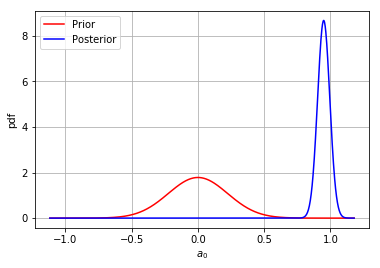

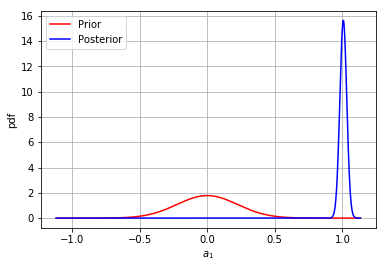

In [6]:
for i in range(0,N):
    pscale = 5
    Wpriormin = m0[i]-pscale*np.sqrt(P0[i,i])
    Wpriormax = m0[i]+pscale*np.sqrt(P0[i,i])
    Wpostmin = m[i]-pscale*np.sqrt(P[i,i])
    Wpostmax = m[i]+pscale*np.sqrt(P[i,i])
    Wgrid = np.linspace(min(Wpriormin,Wpostmin),max(Wpostmax,Wpriormax),1000)
    WpriorN = st.multivariate_normal.pdf(Wgrid,m0[i],(P0[i,i]))
    WpostN = st.multivariate_normal.pdf(Wgrid,m[i],(P[i,i]))
    fig = plt.figure(i+1)
    plt.plot(Wgrid,WpriorN,'r-',label='Prior')
    plt.plot(Wgrid,WpostN,'b-',label='Posterior')
    plt.grid(True)
    plt.xlabel(r'$a_'+str(i)+'$')
    plt.ylabel('pdf')
    plt.legend(loc='best', numpoints = 1)
    plt.savefig('BLR_PDF_W'+str(i)+'.pdf',bbox_inches='tight')

Posterior predictive distribution:

In [7]:
Mnew = 100
Xextra = 2
Xnew = np.linspace(min(Xobs)-Xextra,max(Xobs)+Xextra,Mnew)
PhiNew = PhiMat(Xnew)
PredVar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/rho
PredMean = np.matmul(PhiNew,m)

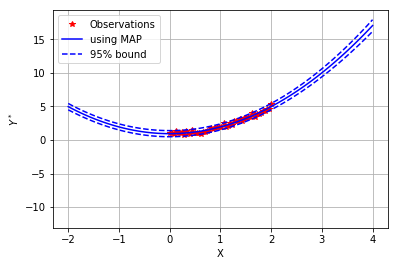

In [8]:
fig = plt.figure(N+1)
plt.plot(Xobs,Yobs,'r*',label='Observations')
plt.plot(Xnew,PredMean,'b-',label='using MAP')
plt.plot(Xnew,PredMean+2*np.sqrt(np.diag(PredVar)),'b--',label='95% bound')
plt.plot(Xnew,PredMean-2*np.sqrt(np.diag(PredVar)),'b--')
plt.grid(True)
plt.ylim([min(Yobs)-3*abs(max(Yobs)-min(Yobs)),max(Yobs)+3*abs(max(Yobs)-min(Yobs))])
plt.ylabel(r'$Y^*$')
plt.xlabel('X')
plt.legend(loc='best', numpoints = 1)
plt.savefig('BLR_predictions.pdf',bbox_inches='tight')
